In [1]:
%matplotlib inline
import matplotlib.pyplot as plt       # Allows to do plots
import fenics as fe                   # Allors to use the FEniCS functions
import os                             # Allows to use path
import pandas as pd                   # Allows to use data in tables
import time                           # allows to measure real time

In [2]:
# --------------------------------
# General Parameters
# --------------------------------

fe.parameters["form_compiler"]["representation"] = "uflacs"
fe.parameters["form_compiler"]["quadrature_degree"] = 2

In [3]:
# --------------------------------
# Create XMDF file for the results
# --------------------------------

out_path = 'Test'
os.makedirs(out_path, exist_ok=True)

In [4]:
# --------------------------------
# Test Parameters
# --------------------------------

Regions = ["Basal Ganglia", "Corona Radiata", "Corpus Callosum", "Cortex"]
Region = Regions[1]

Tests = ['Traction', 'Compression', 'Simple Shear']
Test  = Tests[0]

Models = ['Hybrid Neo-Hookean', 'Hybrid Ogden', 'Incompressible Ogden', 'Compressible Neo-Hookean', 'Compressible Ogden']
Model = Models[4]


IniS   = 1.0                            # Initial state (-)
FinS   = 1.1                            # Final state/stretch (-)
NSteps = 10                             # Number of steps (-)

SSteps = round((FinS-IniS)/NSteps,3)    # Stretch step (-)


print(Test, 'of', Region, 'from', IniS, 'to', FinS)

Traction of Corona Radiata from 1.0 to 1.1


In [5]:
# --------------------------------
# FE Parameters
# --------------------------------

# Geometry (mm)
Length    = 5
Thickness = 5
Height    = 5

# Discretization
Nelements = 2
Type      = 'Lagrange'
PolDegree = 1

# Mesh
mesh = fe.BoxMesh(fe.Point(-Length/2, -Thickness/2, -Height/2),
                  fe.Point( Length/2,  Thickness/2,  Height/2),
                  Nelements, Nelements, Nelements)

# Original surface normals of the cube
Normals = fe.FacetNormal(mesh)

# Functions spaces

V_ele = fe.VectorElement(Type, mesh.ufl_cell(), PolDegree+1)
V = fe.VectorFunctionSpace(mesh, Type, PolDegree)

W_ele = fe.FiniteElement(Type, mesh.ufl_cell(), PolDegree)
W     = fe.FunctionSpace(mesh, Type, PolDegree)

Y_ele = fe.MixedElement([V_ele, W_ele])
Y     = fe.FunctionSpace(mesh,Y_ele)

Z_ele = fe.TensorElement(Type, mesh.ufl_cell(), PolDegree)
Z     = fe.TensorFunctionSpace(mesh, Type, PolDegree)

# Finite element functions
if Model == Models[0] or Model == Models[1]:
    dup   = fe.TrialFunction(Y)
    vq    = fe.TestFunction(Y)
    up    = fe.Function(Y)
    
    u, p  = fe.split(up)
    
else:
    du    = fe.TrialFunction(V)
    v     = fe.TestFunction(V)
    u     = fe.Function(V)
    p     = fe.Function(W)

mesh

In [6]:
# --------------------------------
# Mechanics Parameters
# --------------------------------

# Region of the brain
if Region == Regions[0]:
    Rn = "BasalGanglia"
    Rd = "BG"    
elif Region == Regions[1]:
    Rn = "CoronaRadiata"
    Rd = "CR"
elif Region == Regions[2]:
    Rn = "CorpusCallosum"
    Rd = "CC"
elif Region == Regions[3]:
    Rn = "Cortex"
    Rd = "C"

# Material coefficient importing
MainFolder = "Budday2019Data"
AbaqusFolder = "AbaqusData"

NeoHookeanCoefs = pd.read_pickle(os.path.join("..", MainFolder, 'NeoHookeanCoefs'))
OgdenCoefs = pd.read_pickle(os.path.join("..", MainFolder, 'OgdenCoefs'))

MuH   = NeoHookeanCoefs.loc[Rd, 'Simultaneous mu']
MuO   = OgdenCoefs.loc[Rd, 'Simultaneous mu']
alpha = OgdenCoefs.loc[Rd, 'Simultaneous alpha']

# Attribute coefficient for the model
if Model == Models[0] or Model == Models[3]:
    Mu = MuH                         #   (kPa)
    
elif Model == Models[1] or Model == Models[2]:
    Mu = MuO                         #   (kPa)

elif Model == Models[4]:
    AbaqusFile = 'OptimizedOgdenParametersCR.csv'
    Abaqusdf = pd.read_csv(os.path.join("..", AbaqusFolder, AbaqusFile),delimiter=";",
               header=None, usecols=[1,2,3], names = ['Mu','Alpha','D'])
        
    if Test == Tests[0]:
        Mu   = Abaqusdf['Mu'][6]
        alpha = Abaqusdf['Alpha'][6]
        D     = Abaqusdf['D'][6]

    if Test == Tests[1]:
        Mu   = Abaqusdf['Mu'][0]
        alpha = Abaqusdf['Alpha'][0]
        D     = Abaqusdf['D'][0]

    if Test == Tests[2]:
        Mu   = Abaqusdf['Mu'][3]
        alpha = Abaqusdf['Alpha'][3]
        D     = Abaqusdf['D'][3]

# Material Constants
Nu     = 0.49                        #   (-)
E      = 2*Mu*(1+Nu)                 #   (kPa)
Lambda = 2*Mu*Nu/(1-2*Nu)            #   (kPa)
Kappa  = 2*Mu*(1+Nu)/(3*(1-2*Nu))    #   (kPa)
D0     = 3*(1-2*Nu)/(Mu*(1+Nu))

print('Material properties :')
print('Nu     =  %.3f (-)'%Nu)
print('Mu     =  %.3f (kPa)'%Mu)
print('E      =  %.3f (kPa)'%E)
print('Lambda =  %.3f (kPa)'%Lambda)
print('Kappa  =  %.3f (kPa)'%Kappa)
print('Alpha  = %.3f (-) (Ogden)'%alpha)
print('D0     = %.3f (1/kPa) (Compressible Ogden)'%D0)


# Kinematics
d   = u.geometric_dimension()
I   = fe.Identity(d)                  # Identity tensor
F   = I + fe.grad(u)                  # Deformation gradient
F   = fe.variable(F)                  # !!! needed to be able to differentiate strain energydensity function wrt F for stress computation
eps = 1/2 * (F + F.T - I)             # Small (or infinitesimal) strain tensor
C   = F.T*F                           # Right Cauchy-Green deformation tensor
E   = 1/2 * (C - I)                   # Green-Lagrange strain tensor

Material properties :
Nu     =  0.490 (-)
Mu     =  0.458 (kPa)
E      =  1.366 (kPa)
Lambda =  22.461 (kPa)
Kappa  =  22.767 (kPa)
Alpha  = -59.367 (-) (Ogden)
D0     = 0.088 (1/kPa) (Compressible Ogden)


In [7]:
# --------------------------------
# Invariants
# --------------------------------

# Jacobian of F
J   = fe.det(F)

# Trace of C
Ic = fe.tr(C)

# First invariant of Right Cauchy-Green deformation tensor
def I1(T):
    return fe.tr(T)

def I2(T):
    t1 = T[0,0]*T[1,1] + T[0,0]*T[2,2] + T[1,1]*T[2,2]
    t2 = T[0,1]*T[0,1] + T[0,2]*T[0,2] + T[1,2]*T[1,2]
    return t1 - t2

def I3(T):
    return fe.det(T)

# Define function necessary for eigenvalues computation
def v_inv(T):
    return (I1(T)/3.)**2 - I2(T)/3.

def s_inv(T):
    return (I1(T)/3.)**3 - I1(T)*I2(T)/6. + I3(T)/2.

def phi_inv(T):
    arg = s_inv(T)/v_inv(T)*fe.sqrt(1./v_inv(T))
    # numerical issues if arg~0 -> https://fenicsproject.org/qa/12299/nan-values-when-computing-arccos-1-0-bug/
    arg_cond = fe.conditional( fe.ge(arg,  1-fe.DOLFIN_EPS),  
                                     1-fe.DOLFIN_EPS, 
                                     fe.conditional( fe.le(arg, -1+fe.DOLFIN_EPS), -1+fe.DOLFIN_EPS, arg ))
    return fe.acos(arg_cond)/3.

# Eigenvalues of the strech tensor C
lambda_1 = Ic/3. + 2*fe.sqrt(v_inv(C))*fe.cos(phi_inv(C))
lambda_2 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. + phi_inv(C))
lambda_3 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. - phi_inv(C))

In [8]:
# --------------------------------
# Constitutive Models
# --------------------------------

# Hybrid Neo-Hookean
HNH = (Mu/2)*(Ic - 3) - p*fe.ln(J)

# Hybrid Modified one-term Ogden
HOg = 2 * Mu * (lambda_1**(alpha/2.) + lambda_2**(alpha/2.) + lambda_3**(alpha/2.) - 3) / alpha**2 - p*fe.ln(J)

# Incompressible Modified one-term Ogden
IOg = 2 * Mu * (lambda_1**(alpha/2.) + lambda_2**(alpha/2.) + lambda_3**(alpha/2.) - 3) / alpha**2

# Compressible Neo-Hookean
CNH = (Mu/2)*(Ic - 3) - Mu*fe.ln(J) + (Lambda/2)*(fe.ln(J))**2

# Compressible Modified one-term Ogden
COg = 2 * Mu * (J**(-1/3)*lambda_1**(alpha/2.) 
              + J**(-1/3)*lambda_2**(alpha/2.) 
              + J**(-1/3)*lambda_3**(alpha/2.) - 3) / alpha**2 + 1/D0 * (J-1)**2

# Set of constitutive models
Constitutive_Models = [HNH, HOg, IOg, CNH, COg]

In [9]:
# --------------------------------
# Subdomains
# --------------------------------

# Define boundaries
class LowerSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], -Height/2, tol)
    
class UpperSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], Height/2, tol)

# Define Integration over subdomains
domains_facets  = fe.MeshFunction('size_t', mesh, mesh.geometric_dimension()-1)
ds = fe.Measure('ds', domain=mesh, subdomain_data=domains_facets)

# Mark facets all domain facets with 0
domains_facets.set_all(0)

# Mark bottom facets with 1
bottom = LowerSide()
bottom.mark(domains_facets, 1)

# Mark upper facets with 2
upper = UpperSide()
upper.mark(domains_facets, 2)

# Save in .pvd file
boundaries_file = fe.File(os.path.join(out_path, "boundaries.pvd"))
boundaries_file << domains_facets

In [10]:
# --------------------------------
# Boundary conditions
# --------------------------------

# Fixed side
u_0 = fe.Constant((0, 0, 0))                                                           # No displacement

# Test performed
if Test == Tests[0]:
    u_1 = fe.Expression(('0', '0', '(s-1)*h'), degree=1, s = IniS, h = Height )        # Displacement imposed
    Dir = fe.Constant((0,0,1))                                                         # Direction of the deformation
    Delta  = 1E-3                                                                      # Delta necessary to avoid solving issue
elif Test == Tests[1]:
    u_1 = fe.Expression(('0', '0', '(s-1)*h'), degree=1, s = IniS, h = Height )        # Displacement imposed
    Dir = fe.Constant((0,0,1))                                                         # Direction of the deformation
    Delta  = -1E-3                                                                     # Delta necessary to avoid solving issue
elif Test == Tests[2]:
    u_1 = fe.Expression(('s*h', '0', '0'), degree=1, s = IniS, h = Height )            # Displacement imposed
    Dir = fe.Constant((1,0,0))                                                         # Direction of the deformation
    Delta  = 1E-3                                                                      # Delta necessary to avoid solving issue

# Apply boundary conditions
if Model == Models[0] or Model == Models[1]:
    bcl = fe.DirichletBC(Y.sub(0), u_0, domains_facets, 1)
    bcu = fe.DirichletBC(Y.sub(0), u_1, domains_facets, 2)
else:
    bcl = fe.DirichletBC(V, u_0, domains_facets, 1)
    bcu = fe.DirichletBC(V, u_1, domains_facets, 2)
    
# Set of boundary conditions
bcs = [bcl, bcu]

In [11]:
# --------------------------------
# Problem definition
# --------------------------------

def Pi2Solver(Pi):
    
    # Define derivatives
    if Model == Models[0] or Model == Models[1]:
        # First directional derivative of the potential energy (a linear form in the test function vq)
        Fpi = fe.derivative(Pi,up,vq)
        # First directional derivative of the potential energy (a bilinear form in the test function vq and the trial function dup) (Jacobian of Fpi)
        Jac = fe.derivative(Fpi,up,dup)
    else:
        # First directional derivative of the potential energy (a linear form in the test function v)
        Fpi = fe.derivative(Pi,u,v)
        # First directional derivative of the potential energy (a bilinear form in the test function v and the trial function du) (Jacobian of Fpi)
        Jac = fe.derivative(Fpi,u,du)
    
    # Define the solver
    ffc_options = {"optimize": True, \
    "eliminate_zeros": True, \
    "precompute_basis_const": True, \
    "precompute_ip_const": True, \
    "quadrature_degree": 2, \
    "representation" : "uflacs" }
    
    # Define the problem
    if Model == Models[0] or Model == Models[1]:
        problem = fe.NonlinearVariationalProblem(Fpi, up, bcs, Jac,form_compiler_parameters=ffc_options)
    else:
        problem = fe.NonlinearVariationalProblem(Fpi, u, bcs, Jac,form_compiler_parameters=ffc_options)
        
    solver = fe.NonlinearVariationalSolver(problem)
    
    # Set solver parameters (optional)    
    prm = solver.parameters
    
    if Model == Models[0] or Model == Models[1]:
        prm['newton_solver']['linear_solver'] = 'mumps'
        
#         prm['newton_solver']['linear_solver'] = 'petsc'
#         prm['newton_solver']['linear_solver'] = 'gmres'
#         prm['newton_solver']['preconditioner'] = 't_krylov_solver_preconditioners'
    
    else:
        prm['nonlinear_solver'] = 'newton'
        prm['newton_solver']['linear_solver'] = 'cg'
        prm['newton_solver']['preconditioner'] = 'icc'
    
#     prm['newton_solver']['error_on_nonconvergence'] = True
#     prm['newton_solver']['absolute_tolerance'] = 1E-9
#     prm['newton_solver']['relative_tolerance'] = 1E-8
#         prm['newton_solver']['maximum_iterations'] = 100
#     prm['newton_solver']['relaxation_parameter'] = 1.0

#     prm['newton_solver']['lu_solver']['report'] = True
# #     prm['newton_solver']['lu_solver']['reuse_factorization'] = False
# #     prm['newton_solver']['lu_solver']['same_nonzero_pattern'] = False
#     prm['newton_solver']['lu_solver']['symmetric'] = False

#     prm['newton_solver']['krylov_solver']['error_on_nonconvergence'] = True
#     prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-7
#     prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-5
#         prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
        prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
    
    return solver

In [12]:
# --------------------------------
# Estimation of the results (only necessary for Ogden)
# --------------------------------

if Model == Models[1] or Model == Models[2] or Model == Models[4]:
    
    # Set Incompressible Constitutive Model
    if Model == Models[1]:
        Psi = Constitutive_Models[0]

    else:
        Psi = Constitutive_Models[3]

    # Total potential energy 
    Pi = Psi * fe.dx

    # Set problem to solve
    solver = Pi2Solver(Pi)

    # Update current state
    u_1.s = IniS + Delta

    # Compute solution and save displacement
    solver.solve()

    # If incompressible, split displacement and pressure
    if Model == Models[0] or Model == Models[1]:
        u, p = fe.split(up)

In [13]:
# --------------------------------
# Solve
# --------------------------------

# Set Constitutive Model
if Model == Models[0]:
    Psi = Constitutive_Models[0]
elif Model == Models[1]:
    Psi = Constitutive_Models[1]
elif Model == Models[2]:
    Psi = Constitutive_Models[2]
elif Model == Models[3]:
    Psi = Constitutive_Models[3]
elif Model == Models[4]:
    Psi = Constitutive_Models[4]

# Total potential energy 
Pi = Psi * fe.dx 

solver = Pi2Solver(Pi)

# Data frame to store values
cols  = ['Stretches','Pzz','pzz', 'Itimes']
df = pd.DataFrame(columns=cols, index=range(int(round(NSteps))+1))

# Results File
results = xdmffile = fe.XDMFFile(os.path.join(out_path, Model, str(NSteps) + ' Steps', 'Nu' + str(Nu) + '_' + str(Nelements) + 'Elements_' + Test + ".xdmf"))
results.parameters["flush_output"] = True
results.parameters["functions_share_mesh"] = True

StretchState = IniS + Delta
for i in range(NSteps+1):
    
    # Record iteration time
    tic = time.time()
    
    # Update current state
    u_1.s = StretchState
    
    print('Stretch state:   ', '%.2f'%StretchState , '(-)')
    
    # Compute solution and save displacement
    solver.solve()
    
    # If incompressible, split displacement and pressure
    if Model == Models[0] or Model == Models[1]:
        u, p = fe.split(up)
    
    u_project = fe.project(u, V, solver_type='cg')
    p_project = fe.project(p, W, solver_type='cg')
    u_project.rename('displacement (mm)', '')
    p_project.rename('pressure', '')
    results.write(u_project,i)
    results.write(p_project,i)

    # First Piola Kirchoff (nominal) stress
    print("Nominal stress derivation and saving to file")
    P = fe.diff(Psi, F)
    P_project = fe.project(P, Z, solver_type='cg')
    P_project.rename("Nominal stress tensor (kPa)", "")
    results.write(P_project,i)
    
    # Compute nominal stress vector
    pv = fe.dot(P,fe.Constant((0,0,1)))                           # Nominal stress vectors normal to upper surface
    pv_project = fe.project(pv, V)
    pv_project.rename("Nominal stress vector (kPa)","")
    results.write(pv_project,i)
                        
    # Compute forces based on stress vectors
    fpv = fe.assemble(fe.inner(pv,Dir)*ds(2))          # Reaction force over the volume in direction of interest
    
    # References values
    Area = fe.assemble( 1 * ds(2))
    
    # Save values to table
    df.loc[i].Stretches = StretchState
    
    # Using average stress tensor
    if Test == Tests[2]:
        df.loc[i].Pzz = fe.assemble(P[0,0]*ds(2))/Area
    else:
        df.loc[i].Pzz = fe.assemble(P[2,2]*ds(2))/Area
    
    # Using average stress vector
    if Test == Tests[2]:
        df.loc[i].pzz = fpv/Area
    else:
        df.loc[i].pzz = fpv/Area    

    # Update stretch state
    if i == 0:
        StretchState -= Delta
        
    StretchState += SSteps
    
    # Save iteration time
    toc = time.time()
    df.loc[i].Itimes = toc-tic

Stretch state:    1.00 (-)
Nominal stress derivation and saving to file
Stretch state:    1.01 (-)
Nominal stress derivation and saving to file
Stretch state:    1.02 (-)
Nominal stress derivation and saving to file
Stretch state:    1.03 (-)
Nominal stress derivation and saving to file
Stretch state:    1.04 (-)
Nominal stress derivation and saving to file
Stretch state:    1.05 (-)
Nominal stress derivation and saving to file
Stretch state:    1.06 (-)
Nominal stress derivation and saving to file
Stretch state:    1.07 (-)
Nominal stress derivation and saving to file
Stretch state:    1.08 (-)
Nominal stress derivation and saving to file
Stretch state:    1.09 (-)
Nominal stress derivation and saving to file
Stretch state:    1.10 (-)
Nominal stress derivation and saving to file


   Stretches         Pzz         pzz     Itimes
0      1.001  0.00436292  0.00436292  0.0917284
1       1.01    0.110903    0.110903   0.153504
2       1.02    0.229999    0.229999  0.0984509
3       1.03    0.354504    0.354504  0.0922356
4       1.04    0.486514    0.486514  0.0872428
5       1.05    0.626458    0.626458   0.089587
6       1.06    0.773922    0.773922  0.0851624
7       1.07    0.928208    0.928208  0.0877671
8       1.08     1.08859     1.08859  0.0852058
9       1.09     1.25441     1.25441  0.0835369
10       1.1     1.42502     1.42502  0.0853069


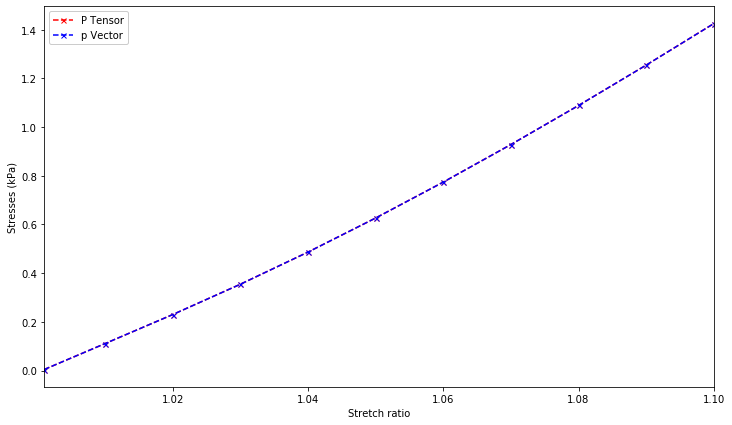

In [14]:
# --------------------------------
# Save Results
# --------------------------------

# Tables
df.to_pickle(os.path.join(out_path, Model, str(NSteps) + ' Steps', 'Nu' + str(Nu) + '_' + str(Nelements) + 'Elements_' + Test + 'Stresses'))

print(df)

# Plots
plt.rc('figure', figsize=[12,7])
fig, ax = plt.subplots(1, 1)
Xaxis = 'Stretches'

df.plot(ax = ax, x = Xaxis, y = 'Pzz', color = 'r', linestyle = '--', label = 'P Tensor', marker = 'x', markersize = 5)
df.plot(ax = ax, x = Xaxis, y = 'pzz', color = 'b', linestyle = '--', label = 'p Vector', marker = 'x', markersize = 5)

ax.set_xlabel('Stretch ratio')
ax.set_ylabel('Stresses (kPa)')
ax.set_xlim(df['Stretches'][0],df['Stretches'][NSteps])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.02))
ax.legend(loc='upper left', frameon=True, framealpha=1)
plt.savefig(os.path.join(out_path, Model, str(NSteps) + ' Steps', 'Nu' + str(Nu) + '_' + str(Nelements) + 'Elements_'+ Test + 'Stresses_Comparison.pdf'))

Plot selected :  Traction of Corona Radiata using Compressible Ogden Model


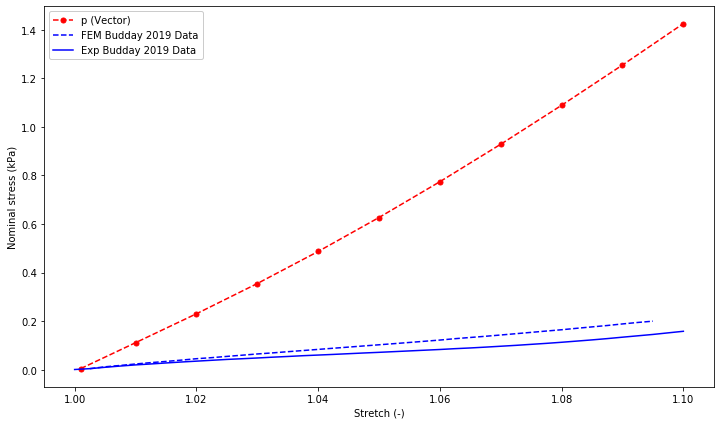

In [15]:
# Import reference data
if Test  == Tests[0]:
    FEMData = "Tension_OgdenFEM_Dat.csv"
    ExpData = "Tension_ExpDat.csv"
    Test = "Traction"
    Xaxis = "Stretch (-)"
    Yaxis = "Nominal stress (kPa)"
elif Test  == Tests[1]:
    if Model == Models[0] or Model == Models[3]:
        FEMData = "Compression_NeoHookFEM_Dat.csv"
    elif Model == Models[1] or Model == Models[2] or Model == Models[4]:
        FEMData = "Compression_OgdenFEM_Dat.csv"
    ExpData = "Compression_ExpDat.csv"
    Test = "Compression"
    Xaxis = "Stretch (-)"
    Yaxis = "Nominal stress (kPa)"
elif Test  == Tests[2]:
    FEMData = "SimpleShear_OgdenFEM_Dat.csv"
    ExpData = "SimpleShear_ExpDat.csv"
    Test = "Simple Shear"
    Xaxis = "Shear (-)"
    Yaxis = "Shear stress (kPa)"

FEMData = pd.read_csv(os.path.join("..", MainFolder, Rn, Rd + "_" + FEMData),delimiter=";", decimal=",",names=["FEM " + Xaxis,"FEM " + Yaxis])
ExpData = pd.read_csv(os.path.join("..", MainFolder, Rn, Rd + "_" + ExpData),delimiter=";", decimal=",",names=["Exp " + Xaxis,"Exp " + Yaxis])

datadf = pd.concat([FEMData, ExpData], axis=1)

# Print the output
# print(outputdf)
# print(datadf)

# Plot
print("Plot selected : ", Test, "of" ,Region, "using", Model, "Model")
fig, ax = plt.subplots(1, 1)
df.plot(ax = ax, x = 'Stretches', y = 'pzz', color = 'r', linestyle = '--', label = 'p (Vector)', marker = 'o', markersize = 5)

datadf.plot(ax = ax, x = "FEM " + Xaxis, y = "FEM " + Yaxis, color = 'b', linestyle = '--', label = 'FEM Budday 2019 Data')
datadf.plot(ax = ax, x = "Exp " + Xaxis, y = "Exp " + Yaxis, color = 'b', linestyle = '-', label = 'Exp Budday 2019 Data')
ax.set_xlabel(Xaxis)
ax.set_ylabel(Yaxis)
if Test  == Tests[1]:
    ax.set_ylim(0,df['pzz'][10]*1.5)
    ax.set_xlim(1,df['Stretches'][10])
# ax.set_xlim(df['Stretches'][0],df['Stretches'][NSteps])
# ax.set_ylim(0,df['pzz'][NSteps]*1.05)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.02))
ax.legend(loc='upper left', frameon=True, framealpha=1)
plt.savefig(os.path.join(out_path, Model, str(NSteps) + ' Steps', 'Nu' + str(Nu) + '_' + str(Nelements) + 'Elements_'+ Test + 'Results_Comparison.pdf'))

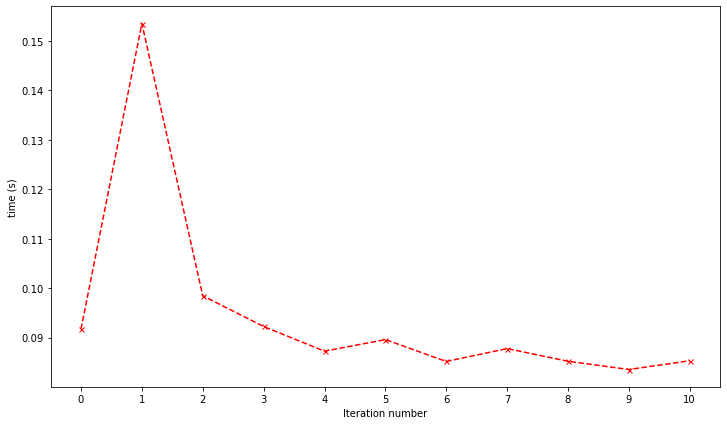

In [16]:
# Plot iteration time

ax = df.plot(y = 'Itimes', color = 'r', linestyle = '--', marker = 'x', markersize = 5)

ax.set_xlabel('Iteration number')
ax.set_ylabel('time (s)')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend(loc='upper left', frameon=True, framealpha=1)
ax.get_legend().remove()
plt.savefig(os.path.join(out_path, Model, str(NSteps) + ' Steps', 'Nu' + str(Nu) + '_' + str(Nelements) + 'Elements_'+ Test + 'IterationTime.pdf'))